# Variational Auto Encoder 

In [1]:
import torch 
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.optim import Adam,RMSprop
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [2]:
data_path="/data"
transform=transforms.Compose([transforms.ToTensor()])
train_data=FashionMNIST(root=data_path,train=True,transform=transform,download=True)
test_data=FashionMNIST(root=data_path,train=False,transform=transform,download=True)

In [3]:
BATCH_SIZE=16

In [4]:
train_data_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_data_loader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

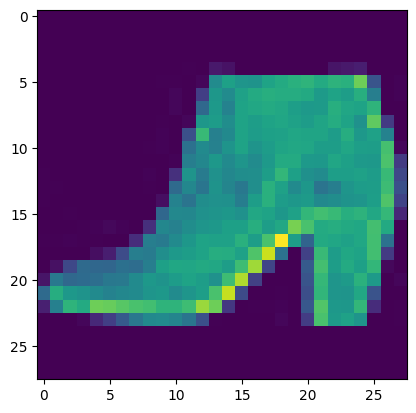

In [5]:
from matplotlib import pyplot as plt
for i in train_data_loader:
    plt.imshow(i[0][0].squeeze())
    plt.show()
    # print(i[0].shape)
    break

In [6]:
# device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")

In [16]:
class Varational_Auto_Encoder(nn.Module):
    def __init__(self,input_dim,hidden_dim,latent_dim):
        super(Varational_Auto_Encoder,self).__init__()
        self.input_dims=input_dim
        self.hidden_dims=hidden_dim
        self.latent_dim=latent_dim
        self.mean=nn.Linear(self.hidden_dims,self.latent_dim)
        self.log_var=nn.Linear(self.hidden_dims,self.latent_dim)
        self.encoder=nn.Sequential(
            nn.Linear(self.input_dims,self.hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dims,self.hidden_dims),
            nn.LeakyReLU()
        )
        self.decoder=nn.Sequential(
            nn.Linear(self.latent_dim,self.hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dims,self.hidden_dims),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dims,self.input_dims),
            nn.Sigmoid()
        )
    def parameterized_mean_and_variance(self,data):
        mean=self.mean(data)
        log_var=self.log_var(data)
        return mean,log_var
    def encode(self,x):
        x=self.encoder(x)
        mean,log_var=self.parameterized_mean_and_variance(x)
        return mean,log_var
    def reparameterization(self,mean,log_var):
        std_dev=torch.exp(0.5*log_var)
        epsilon=torch.rand_like(std_dev)
        return mean+std_dev*epsilon

    
    def decode(self,x):
        return self.decoder(x)
    
    def forward(self,data):
        mean,log_var=self.encode(data)
        z=self.reparameterization(mean=mean,log_var=log_var)
        out=self.decode(z)
        return out,mean,log_var

In [17]:
input_dim=784
hidden_dim=20
latent_dim=2
vae=Varational_Auto_Encoder(input_dim=input_dim,hidden_dim=hidden_dim,latent_dim=latent_dim).to(device)

In [18]:
optimizer=Adam(vae.parameters(),lr=0.02)

In [19]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [20]:
device

device(type='cpu')

In [21]:
def train(model, optimizer, epochs, device,x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_data_loader):
            x = x.view(BATCH_SIZE, x_dim)
            x=x/255.0
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*BATCH_SIZE))
    return overall_loss

train(vae, optimizer, epochs=10, device=device)

	Epoch 1 	Average Loss:  7.727191379147232
	Epoch 2 	Average Loss:  6.584166126907523
	Epoch 3 	Average Loss:  6.600057090622929
	Epoch 4 	Average Loss:  6.58565979087852
	Epoch 5 	Average Loss:  6.5823409125530805
	Epoch 6 	Average Loss:  6.5804461735857425
	Epoch 7 	Average Loss:  6.578193108855517
	Epoch 8 	Average Loss:  7.676661169983667
	Epoch 9 	Average Loss:  6.589251856321842
	Epoch 10 	Average Loss:  6.579214144528914


394647.58124542236

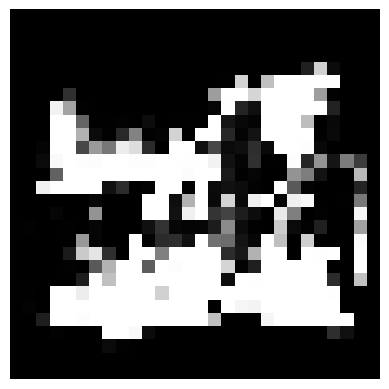

In [32]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = vae.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.2, 3.0)
# generate_digit(1.0,1.0)